# Explore Element Miniscope

+ This notebook will describe the steps for interacting with the data ingested into `workflow-miniscope`.  

In [1]:
import os
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
import datajoint as dj
import matplotlib.pyplot as plt
import numpy as np

from workflow_miniscope.pipeline import lab, subject, session, miniscope

Connecting cbroz@dss-db.datajoint.io:3306


## Workflow architecture

This workflow is assembled from 4 DataJoint elements:
+ [element-lab](https://github.com/datajoint/element-lab)
+ [element-animal](https://github.com/datajoint/element-animal)
+ [element-session](https://github.com/datajoint/element-session)
+ [element-miniscope](https://github.com/datajoint/element-miniscope)

For the architecture and detailed descriptions for each of those elements, please visit the respective links. 

Below is the diagram describing the core components of the fully assembled pipeline.


In [ ]:
dj.Diagram(miniscope) + (dj.Diagram(session.Session) + 1) - 1

## Browsing the data with DataJoint `query` and `fetch` 

+ DataJoint provides functions to query data and fetch.  For a detailed tutorials, visit our [general tutorial site](https://playground.datajoint.io/).

+ Running through the pipeline, we have ingested data of subject3 into the database.

+ Here are some highlights of the important tables.

### `subject.Subject` and `session.Session` tables

In [2]:
subject.Subject() & "subject='subject1'"

subject,sex,subject_birth_date,subject_description
subject1,F,2020-01-01,UCLA Miniscope acquisition


In [3]:
session.Session() & "subject='subject1'"

subject,session_datetime
subject1,2021-01-01 00:00:01


+ Fetch the primary key for the session of interest which will be used later on in this notebook.

In [2]:
session_key = (session.Session & 'subject = "subject1"').fetch1('KEY')

### `miniscope.Scan` and `miniscope.ScanInfo` tables

+ These tables stores the scan metadata within a particular session.

In [5]:
miniscope.RecordingInfo & session_key

subject,session_datetime,recording_id,nchannels number of channels,nframes number of recorded frames,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,fps (Hz) frames per second,gain recording gain,"spatial_downsample e.g. 1, 2, 4, 8. 1 for no downsampling",led_power LED power used in the given recording,time_stamps time stamps of each frame
subject1,2021-01-01 00:00:01,0,1,111770,600,600,nan,nan,20.0,2.0,1,5.0,=BLOB=


In [6]:
miniscope.RecordingInfo.File & session_key

subject,session_datetime,recording_id,recording_file_id,recording_file_path relative to root data directory
subject1,2021-01-01 00:00:01,0,0,subject1/session1/0.avi


### Processing tables

- `ProcessingMethod`: Analysis software
- `ProcessingParamSet`: Parameters for analysis
- `ProcessingTask`: Staging area for pairs of recordings and processing parameters, as either triggered or loaded
- `Processing`: Computed table with a `make` function for loading or triggering analysis
- `Curation`: supports multiple curations of an entry in `ProcessingTask`

In [7]:
miniscope.ProcessingMethod()

processing_method,processing_method_desc
caiman,caiman analysis suite


In [8]:
miniscope.ProcessingParamSet()

paramset_id,processing_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,caiman,Calcium imaging analysis with CaImAn using default parameters,7ebfca75-7997-82ce-c46b-f0cc28f69308,=BLOB=


In [3]:
miniscope.ProcessingTask * miniscope.Processing & session_key

subject,session_datetime,recording_id,paramset_id,processing_output_dir relative to the root data directory,task_mode 'load': load existing results,"processing_time time of generation of this set of processed, segmented results",package_version
subject1,2021-01-01 00:00:01,0,0,subject1/session1/caiman,load,2022-04-27 12:13:32,


In this example workflow, `curation_output_dir` is the same as the `processing_output_dir`, as these results were not manually curated.

In [4]:
miniscope.Curation & session_key

subject,session_datetime,recording_id,paramset_id,curation_id,curation_time time of generation of these curated results,"curation_output_dir output directory of the curated results,",manual_curation has manual curation been performed?,curation_note
subject1,2021-01-01 00:00:01,0,0,0,2022-04-30 12:22:15,subject1/session1/caiman,0,


### `miniscope.MotionCorrection` table

+ After processing and curation, results are passed to the `miniscope.MotionCorrection` and `miniscope.Segmentation` tables.

+ For the example data, the raw data is corrected with rigid and non-rigid motion correction which is stored in `miniscope.MotionCorrection.RigidMotionCorrection` and `miniscope.MotionCorrection.NonRigidMotionCorrection`, respectively. 

+ Lets first query the information for one curation.

In [12]:
miniscope.Curation()

subject,session_datetime,recording_id,paramset_id,curation_id,curation_time time of generation of these curated results,"curation_output_dir output directory of the curated results,",manual_curation has manual curation been performed?,curation_note
subject1,2021-01-01 00:00:01,0,0,0,2022-04-30 12:22:15,subject1/session1/caiman,0,


In [13]:
curation_key = (miniscope.Curation & session_key & 'curation_id=0').fetch1('KEY')

In [14]:
curation_key

{'subject': 'subject1',
 'session_datetime': datetime.datetime(2021, 1, 1, 0, 0, 1),
 'recording_id': 0,
 'paramset_id': 0,
 'curation_id': 0}

In [15]:
miniscope.MotionCorrection.RigidMotionCorrection & curation_key

subject,session_datetime,recording_id,paramset_id,curation_id,outlier_frames mask with true for frames with outlier shifts,y_shifts (pixels) y motion correction shifts,x_shifts (pixels) x motion correction shifts,y_std (pixels) standard deviation of,x_std (pixels) standard deviation of
subject1,2021-01-01 00:00:01,0,0,0,=BLOB=,=BLOB=,=BLOB=,0.0561964,0.0570838


In [16]:
miniscope.MotionCorrection.NonRigidMotionCorrection & curation_key

subject,session_datetime,recording_id,paramset_id,curation_id,outlier_frames mask with true for frames with,block_height (pixels),block_width (pixels),block_count_y number of blocks tiled in the,block_count_x number of blocks tiled in the


+ For non-rigid motion correction, the details for the individual blocks are stored in `miniscope.MotionCorrection.Block`.

In [17]:
miniscope.MotionCorrection.Block & curation_key & 'block_id=0'

subject,session_datetime,recording_id,paramset_id,curation_id,block_id,"block_y (y_start, y_end) in pixel of this block","block_x (x_start, x_end) in pixel of this block",y_shifts (pixels) y motion correction shifts for,x_shifts (pixels) x motion correction shifts for,y_std (pixels) standard deviation of y shifts,x_std (pixels) standard deviation of x shifts


+ Summary images are stored in `miniscope.MotionCorrection.Summary`

    + Reference image - image used as an alignment template

    + Average image - mean of registered frames

    + Correlation image - correlation map (computed during region of interest \[ROI\] detection)

    + Maximum projection image - max of registered frames

In [19]:
miniscope.MotionCorrection.Summary & curation_key

subject,session_datetime,recording_id,paramset_id,curation_id,ref_image image used as alignment template,average_image mean of registered frames,correlation_image correlation map,max_proj_image max of registered frames
subject1,2021-01-01 00:00:01,0,0,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=


+ Lets fetch the `average_image` and plot it.

In [20]:
average_image = (miniscope.MotionCorrection.Summary & curation_key
                ).fetch1('average_image')

TypeError: Invalid shape (1, 600, 600) for image data

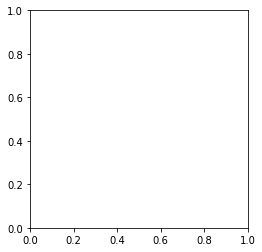

In [21]:
plt.imshow(average_image);

### `miniscope.Segmentation` table

+ Lets fetch and plot a mask stored in the `miniscope.Segmentation.Mask` table for one `curation_id`.

+ Each mask can be associated with a field by the attribute `mask_center_z`.  For example, masks with `mask_center_z=0` are in the field identified with `field_idx=0` in `miniscope.ScanInfo.Field`.

In [ ]:
mask_xpix, mask_ypix = (miniscope.Segmentation.Mask 
                        * miniscope.MaskClassification.MaskType 
                        & curation_key & 'mask_center_z=0' & 'mask_npix > 130'
                       ).fetch('mask_xpix','mask_ypix')

In [ ]:
mask_image = np.zeros(np.shape(average_image), dtype=bool)
for xpix, ypix in zip(mask_xpix, mask_ypix):
    mask_image[ypix, xpix] = True

In [ ]:
plt.imshow(average_image);
plt.contour(mask_image, colors='white', linewidths=0.5);

### `miniscope.MaskClassification` table

+ This table provides the `mask_type` and `confidence` for the mask classification.

In [29]:
miniscope.MaskClassification.MaskType & curation_key & 'mask_id=13'

subject,session_datetime,recording_id,paramset_id,curation_id,mask_classification_method,mask_id,mask_type,confidence
subject1,2021-01-01 00:00:01,0,0,0,caiman_default_classifier,13,soma,nan


### `miniscope.Fluorescence` and `miniscope.Activity` tables

+ Lets fetch and plot the flourescence and activity traces for one mask.

In [37]:
query_cells = (miniscope.Segmentation.Mask 
               * miniscope.MaskClassification.MaskType 
               & curation_key 
               # & 'mask_center_x=0' 
               & 'mask_npix > 130'
              ).proj()

In [38]:
query_cells

subject,session_datetime,recording_id,paramset_id,curation_id,mask_id,mask_classification_method
subject1,2021-01-01 00:00:01,0,0,0,13,caiman_default_classifier
subject1,2021-01-01 00:00:01,0,0,0,15,caiman_default_classifier
subject1,2021-01-01 00:00:01,0,0,0,17,caiman_default_classifier
subject1,2021-01-01 00:00:01,0,0,0,20,caiman_default_classifier
subject1,2021-01-01 00:00:01,0,0,0,21,caiman_default_classifier
subject1,2021-01-01 00:00:01,0,0,0,22,caiman_default_classifier
subject1,2021-01-01 00:00:01,0,0,0,25,caiman_default_classifier
subject1,2021-01-01 00:00:01,0,0,0,26,caiman_default_classifier
subject1,2021-01-01 00:00:01,0,0,0,32,caiman_default_classifier
subject1,2021-01-01 00:00:01,0,0,0,36,caiman_default_classifier


In [40]:
fluorescence_traces = (miniscope.Fluorescence.Trace & query_cells
                      ).fetch('fluorescence', order_by='mask_id')

activity_traces = (miniscope.Activity.Trace & query_cells
                  ).fetch('activity_trace', order_by='mask_id')

sampling_rate = (miniscope.RecordingInfo & curation_key).fetch1('fps') # [Hz]

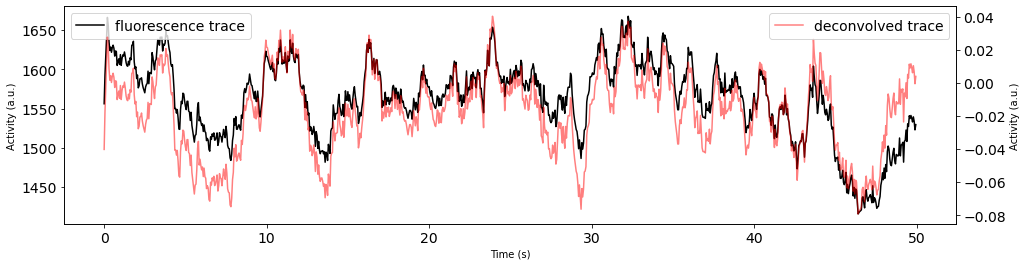

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax2 = ax.twinx()

for f, a in zip(fluorescence_traces, activity_traces):
    ax.plot(np.r_[:f.size] * 1/sampling_rate, f, 'k', label='fluorescence trace')    
    ax2.plot(np.r_[:a.size] * 1/sampling_rate, a, 'r', alpha=0.5, label='deconvolved trace')
    
    break

ax.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

ax.legend(loc='upper left', prop={'size': 14})
ax2.legend(loc='upper right', prop={'size': 14})

ax.set_xlabel('Time (s)')
ax.set_ylabel('Activity (a.u.)')
ax2.set_ylabel('Activity (a.u.)');

## Summary and Next Step

+ This notebook highlights the major tables in the workflow and visualize some of the ingested results. 

+ The next notebook [06-drop](06-drop-optional.ipynb) shows how to drop schemas and tables if needed.